## Import package

In [2]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=4726d41c20670e1bbec3dec3b0116400a9ea6781e089d2b8b7aeec6fa666de76
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [3]:
import warnings
warnings.filterwarnings('ignore')

import datetime
import numpy as np
import pandas as pd
import seaborn as sns
# import pandasql as ps
import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version : ',np.__version__)
print('pandas version : ',pd.__version__)
print('seaborn version : ',sns.__version__)

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

numpy version :  1.26.4
pandas version :  2.2.2
seaborn version :  0.13.2


## Data Preprocessing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
# https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas
data = pd.read_csv('flight.csv',encoding = 'ISO-8859-1' )
data.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SUM_YR_2,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight
0,54993,11/2/2006,12/24/2008,Male,6,.,beijing,CN,31.0,3/31/2014,...,234188.0,580717,3/31/2014,1,3.483254,18,34,0.961639,619760,50
1,28065,2/19/2007,8/3/2007,Male,6,NaN,beijing,CN,42.0,3/31/2014,...,167434.0,293678,3/25/2014,7,5.194245,17,29,1.252314,415768,33
2,55106,2/1/2007,8/30/2007,Male,6,.,beijing,CN,40.0,3/31/2014,...,164982.0,283712,3/21/2014,11,5.298507,18,20,1.254676,406361,26
3,21189,8/22/2008,8/23/2008,Male,5,Los Angeles,CA,US,64.0,3/31/2014,...,125500.0,281336,12/26/2013,97,27.863636,73,11,1.090870,372204,12
4,39546,4/10/2009,4/15/2009,Male,6,guiyang,guizhou,CN,48.0,3/31/2014,...,130702.0,309928,3/27/2014,5,4.788079,47,27,0.970658,338813,39


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          62988 non-null  int64  
 1   FFP_DATE           62988 non-null  object 
 2   FIRST_FLIGHT_DATE  62988 non-null  object 
 3   GENDER             62985 non-null  object 
 4   FFP_TIER           62988 non-null  int64  
 5   WORK_CITY          60719 non-null  object 
 6   WORK_PROVINCE      59740 non-null  object 
 7   WORK_COUNTRY       62962 non-null  object 
 8   AGE                62568 non-null  float64
 9   LOAD_TIME          62988 non-null  object 
 10  FLIGHT_COUNT       62988 non-null  int64  
 11  BP_SUM             62988 non-null  int64  
 12  SUM_YR_1           62437 non-null  float64
 13  SUM_YR_2           62850 non-null  float64
 14  SEG_KM_SUM         62988 non-null  int64  
 15  LAST_FLIGHT_DATE   62988 non-null  object 
 16  LAST_TO_END        629

In [20]:
# Jika ada kolom kategorikal, lakukan encoding
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col] = data[col].astype('category').cat.codes

## Exploratory Data Analysis (EDA)

In [24]:
# Select only numerical features for scaling
numerical_features = data.select_dtypes(include=['number']).columns
data_numeric = data[numerical_features]

# Pilih fitur yang akan digunakan untuk clustering
features = ['FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1', 'SUM_YR_2', 'SEG_KM_SUM',
           'avg_discount', 'Points_Sum', 'AVG_INTERVAL']
# Handling missing values
data[features] = data[features].fillna(data[features].mean())

# Normalisasi data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# Create a new DataFrame with scaled numerical features
new_scaled= pd.DataFrame(data_scaled, columns=features)

# Concatenate scaled numerical features with original non-numerical features
#data_final = pd.concat([data.drop(columns=data_numeric[features]), new_scaled], axis=1)

## Model K-Means Clustering

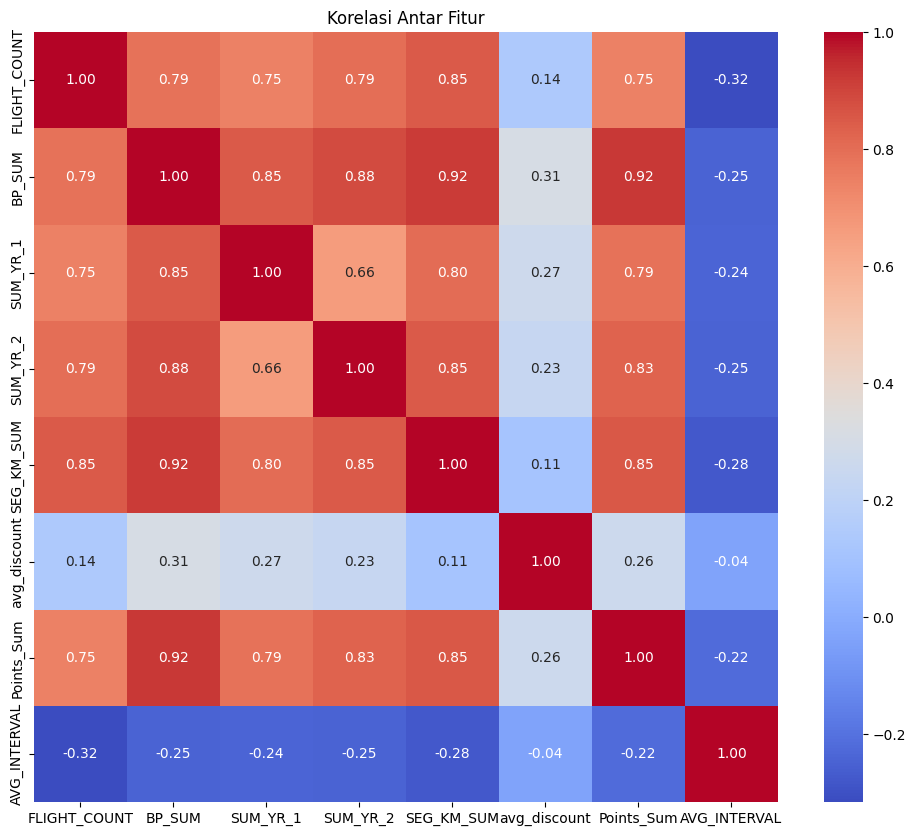

In [25]:
# Melihat korelasi antar fitur menggunakan heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(new_scaled.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Antar Fitur')
plt.show()

<Axes: >

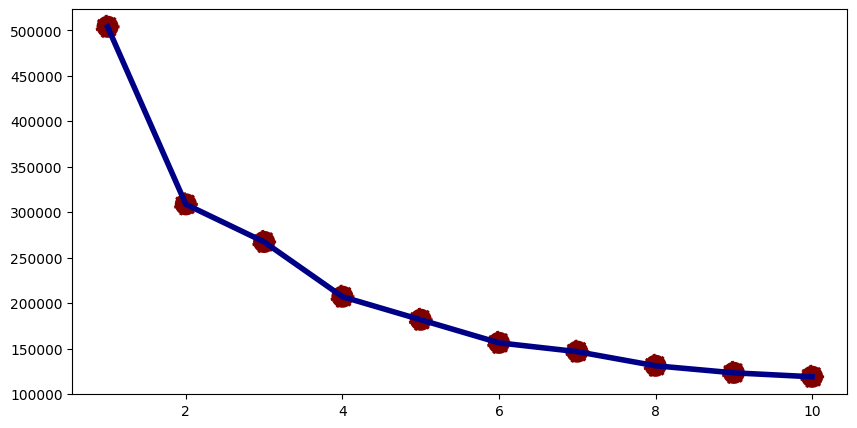

In [26]:
from sklearn.cluster import KMeans
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))

sns.lineplot(x=range(1, 11), y=inertia, color='#000087', linewidth = 4)
sns.scatterplot(x=range(1, 11), y=inertia, s=300, color='#800000',  linestyle='--')


In [39]:
from sklearn.metrics import silhouette_score

range_n_clusters = list(range(2,11))
print(range_n_clusters)

[2, 3, 4, 5, 6, 7, 8, 9, 10]


In [40]:
arr_silhouette_score_euclidean = []
for i in range_n_clusters:
    # Start from 2 clusters
    if i > 1:
      kmeans = KMeans(n_clusters=i).fit(data_scaled)
      preds = kmeans.predict(new_scaled)

      score_euclidean = silhouette_score(new_scaled, preds, metric='euclidean')
      arr_silhouette_score_euclidean.append(score_euclidean)

<Axes: >

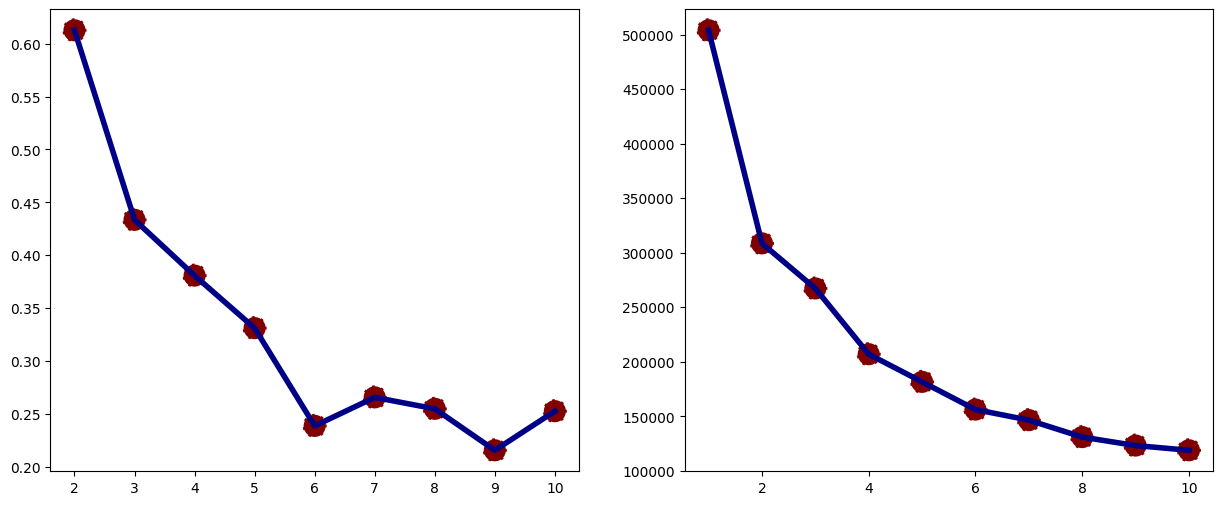

In [41]:
fig, ax = plt.subplots(1,2,figsize=(15, 6))
sns.lineplot(x=range(2,11), y=arr_silhouette_score_euclidean, color='#000087', linewidth = 4, ax=ax[0])
sns.scatterplot(x=range(2,11), y=arr_silhouette_score_euclidean, s=300, color='#800000',  linestyle='--',ax=ax[0])

sns.lineplot(x=range(1, 11), y=inertia, color='#000087', linewidth = 4,ax=ax[1])
sns.scatterplot(x=range(1, 11), y=inertia, s=300, color='#800000',  linestyle='--', ax=ax[1])

### Clustering

In [42]:
## Candidat clustering 2, 3, 4 dan 5
# Implementasi K-Means dengan jumlah cluster optimal
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(data_scaled)

KMeans(n_clusters=4, random_state=42)

In [43]:
data_numeric['clusters'] = kmeans.labels_
data_numeric.head()

,MEMBER_NO,FFP_DATE,FIRST_FLIGHT_DATE,GENDER,FFP_TIER,WORK_CITY,WORK_PROVINCE,WORK_COUNTRY,AGE,LOAD_TIME,...,SEG_KM_SUM,LAST_FLIGHT_DATE,LAST_TO_END,AVG_INTERVAL,MAX_INTERVAL,EXCHANGE_COUNT,avg_discount,Points_Sum,Point_NotFlight,clusters
0,54993,627,1030,1,6,5,842,24,31.0,0,...,580717,352,1,3.483254,18,34,0.961639,619760,50,2
1,28065,1166,3056,1,6,-1,842,24,42.0,0,...,293678,338,7,5.194245,17,29,1.252314,415768,33,2
2,55106,1076,3065,1,6,5,842,24,40.0,0,...,283712,330,11,5.298507,18,20,1.254676,406361,26,2
3,21189,2695,2994,1,5,898,102,104,64.0,0,...,281336,221,97,27.863636,73,11,1.090870,372204,12,2
4,39546,1617,1816,1,6,2102,926,24,48.0,0,...,309928,342,5,4.788079,47,27,0.970658,338813,39,2


## Clustering Analysis

In [44]:
# Analyze the characteristics of each cluster
cluster_summary = data_numeric.groupby('clusters').mean()
print(cluster_summary)


             MEMBER_NO     FFP_DATE  FIRST_FLIGHT_DATE    GENDER  FFP_TIER  \
clusters                                                                     
0         31548.348768  1531.418456        1734.126797  0.750197  4.025224   
1         31264.617240  1545.684711        1740.358341  0.830735  4.341277   
2         30857.056225  1558.946988        1768.795984  0.885141  5.373494   
3         31609.566791  1562.687014        1748.643389  0.731316  4.015894   

            WORK_CITY  WORK_PROVINCE  WORK_COUNTRY        AGE  LOAD_TIME  ...  \
clusters                                                                  ...   
0         2145.934388     859.565020     27.228918  42.141750        0.0  ...   
1         2123.187800     874.849956     26.768952  44.069923        0.0  ...   
2         2019.404819     860.384739     27.861847  45.789686        0.0  ...   
3         2137.575752     849.907677     26.929997  41.601397        0.0  ...   

              SUM_YR_2     SEG_KM_SUM  LAST_

## Viz Clustering with PCA - Optional

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca.fit(data_scaled)
pcs = pca.transform(data_scaled)

data_pca = pd.DataFrame(data = pcs, columns = ['PC 1', 'PC 2'])
data_pca['clusters'] = data_numeric['clusters']
data_pca.head()

,PC 1,PC 2,clusters
0,63.022802,1.237850,2
1,41.681886,3.187265,2
2,40.388396,3.169043,2
3,32.051851,3.263024,2
4,34.446819,0.649119,2


<Axes: xlabel='PC 1', ylabel='PC 2'>

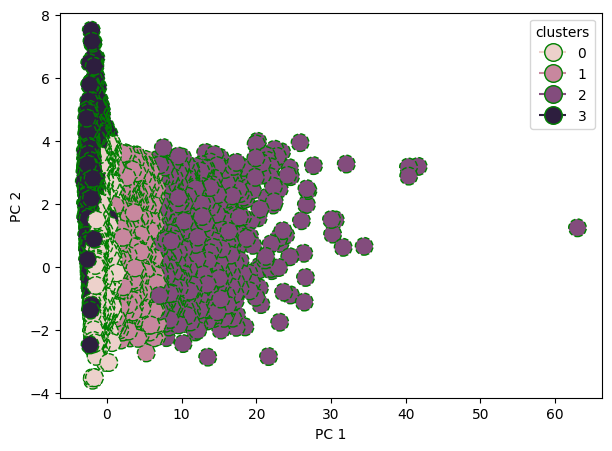

In [38]:
fig, ax = plt.subplots(figsize=(7,5))

sns.scatterplot(
    x="PC 1", y="PC 2",
    hue="clusters",
    edgecolor='green',
    linestyle='--',
    data=data_pca,
    s=160,
    ax=ax
)

## Evaluasi dan Interpretasi

Hasil analisis menunjukkan 4 segmen pelanggan yang berbeda:

Casual Travelers (Cluster 0):
- Pelanggan dengan frekuensi penerbangan rendah
- Fokus pada penawaran promo dan insentif untuk meningkatkan frekuensi
- Perlu pendekatan marketing yang lebih agresif

Loyal High-Value Customers (Cluster 1):
- Pelanggan paling bernilai dengan frekuensi dan pembelian tinggi
- Fokus pada retention dan pengalaman premium
- Berikan reward dan layanan eksklusif

Price-Sensitive Regular Travelers (Cluster 2):
- Pelanggan regular yang sensitif terhadap harga
- Fokus pada penawaran value for money
- Berikan program reward yang menarik

Business Travelers (Cluster 3):
- Pelanggan bisnis dengan frekuensi tinggi
- Fokus pada kenyamanan dan fleksibilitas
- Tawarkan paket corporate dan layanan prioritas

Evaluasi Model:
- Metode Elbow menunjukkan 4 cluster adalah optimal
- Visualisasi PCA menunjukkan separasi yang cukup baik antar cluster
- Karakteristik cluster yang terbentuk memiliki perbedaan yang jelas dan actionable

Rekomendasi umum:
- Customized marketing strategy untuk setiap segment
- Program loyalitas yang berbeda per segment
- Pengembangan produk dan layanan yang sesuai karakteristik segment
- Regular monitoring pergerakan pelanggan antar segment